# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">6. Level 2 Multi-Class Classification</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546    |

---

### **6. Level 2 Multi-Class Classification Notebook**
**Description:**
This notebook handles the **Level 2 Multi-Class Classification model**, which processes cases classified as "Other" in Level 1 and assigns them to their specific class among the rarer categories.

Key steps include:
- Loading the subset of “**Other**” cases from Level 1 predictions.
- **Feature selection:** Focus on features relevant for differentiating between the rare classes.
- **Model training:** Train and evaluate a multi-class classification model to predict the specific class of these cases.
- **Evaluation:** Use multi-class metrics like accuracy, macro-averaged F1-score, and confusion matrices.
- **Output:** Save predictions for merging in the final pipeline.

This notebook specializes in handling the complexity of rare classes, ensuring that all cases are correctly classified.

---

<a id = "toc"></a>

## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Load and Prepare Datasets](#chapter2)
* [3. Setting the Target](#chapter3)
* [4. Feature Selection](#chapter4)
    * [4.1. Preparing the Data](#section_4_1)  
    * [4.2. Numerical Features](#section_4_2) 
        * [4.2.1. LASSO Regression](#section_4_2_1)
        * [4.2.2. Recursive Feature Elimination - RFE](#section_4_2_2)
        * [4.2.3. Feature Importance - Decision Tree](#section_4_2_3)
        * [4.2.4. Feature Importance - Random Forest](#section_4_2_4)
    * [4.3. Categorical Features](#section_4_3)
        * [4.3.1. $\chi ^2$ Test for Independence](#section_4_3_1)
        * [4.3.2. Mutual Information Criterion (MIC)](#section_4_3_2)
    * [4.4. Final Features](#section_4_4)
* [5. Modelling](#chapter5)
  * [5.1. Simple Models](#section_5_1)
    * [5.1.1. Logistic Regression](#section_5_1_1)
    * [5.1.2. Decision Trees](#section_5_1_2)
    * [5.1.3. K-Nearest Neighbors (KNN)](#section_5_1_3)
  * [5.2. Deep Learning Models](#section_5_2)
    * [5.2.1. Feedforward Neural Networks (FNN)](#section_5_2_1)
  * [5.3. Ensemble Models](#section_5_3)
    * [5.3.1. Bagging (Random Forest)](#section_5_3_1)
    * [5.3.2. Boosting (XGBoost, CatBoost, LightGBM)](#section_5_3_2)
    * [5.3.3. Stacking](#section_5_3_3)
* [6. Loading the Results](#chapter6)

# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>

[Back to ToC](#toc)<br>

In [142]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import pickle
import time

# --- Scikit-Learn Modules for Data Partitioning and Preprocessing ---
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Wrapper Methods and Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Embedded Methods
from sklearn.linear_model import LassoCV

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')


#Import from utils the used functions
from utils import plot_importance, cor_heatmap, find_optimal_features_with_rfe, compare_rf_feature_importances
from utils import compare_feature_importances, select_high_score_features_chi2_no_model, select_high_score_features_MIC, metrics

In this topic we will also import the pre-saved feature categories dictionary from Notebook 3, ensuring consistency in feature grouping for feature selection and modeling.

In [143]:
# Load the feature categories dictionary
feature_categories_file = "feature_categories.pkl"
with open(feature_categories_file, "rb") as file:
    feature_categories = pickle.load(file)

# 2. Load and Prepare Datasets 📁<a class="anchor" id="chapter2"></a>

[Back to ToC](#toc)<br>

Now that we preprocessed the dataset in notebook 3. we will upload those datasets

In [144]:
#Import the datasets
X_train = pd.read_csv("../processed_datasets/X_train_model.csv", index_col="Claim Identifier")
X_val = pd.read_csv("../processed_datasets/X_val_model.csv", index_col="Claim Identifier")
df_test = pd.read_csv("../Data_Temporary/df_test_predictions_not5.csv", index_col="Claim Identifier")

In [145]:
X_train.head(2)

,Age at Injury,IME-4 Count,Agreement Reached,Income_Category,Accident_Quarter,Accident_Year,Accident Day,Age Group,promptness_category,promptness_C2_category,...,Industry Code_freq,County of Injury_freq,District Name_freq,WCIO Cause of Injury Code_freq,WCIO Nature of Injury Code_freq,WCIO Part Of Body Code_freq,Carrier Name_freq,Body_Part_Category_freq,Injury_Nature_Category_freq,Carrier Type Merged_freq
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6099734,67,4.0,0.0,1,3,2022,3,1,3,3,...,34856,34897,216798,9648,44601,38469,11544,96343,404174,228492
5796182,30,0.0,0.0,1,3,2021,5,2,7,7,...,34856,13901,68763,6081,88312,15038,11163,96343,404174,228492


In [146]:
X_val.head(2)

,Age at Injury,IME-4 Count,Agreement Reached,Income_Category,Accident_Quarter,Accident_Year,Accident Day,Age Group,promptness_category,promptness_C2_category,...,Industry Code_freq,County of Injury_freq,District Name_freq,WCIO Cause of Injury Code_freq,WCIO Nature of Injury Code_freq,WCIO Part Of Body Code_freq,Carrier Name_freq,Body_Part_Category_freq,Injury_Nature_Category_freq,Carrier Type Merged_freq
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5730729,52,1.0,0.0,4,2,2021,1,0,7,7,...,73733,42680,216798,23476,122811,15038,88862.0,96343,404174,88862
6038049,28,0.0,0.0,1,2,2022,5,2,1,1,...,21175,42680,216798,8659,4398,6314,88862.0,45491,404174,88862


We will also upload the y train and y_val.

In [147]:
# Load the arrays
y_train = np.load("../processed_datasets/y_train_preprocessed.npy", allow_pickle=True)
y_val =  np.load("../processed_datasets/y_val_preprocessed.npy", allow_pickle=True)

In [148]:
y_train

array(['4. TEMPORARY', '3. MED ONLY', '2. NON-COMP', ..., '4. TEMPORARY',
       '2. NON-COMP', '2. NON-COMP'], dtype=object)

In [149]:
y_val

array(['2. NON-COMP', '2. NON-COMP', '4. TEMPORARY', ..., '3. MED ONLY',
       '4. TEMPORARY', '2. NON-COMP'], dtype=object)

In [150]:
df_test['Pred_notebook_5'].value_counts()

2. NON-COMP     222416
4. TEMPORARY    154506
Name: Pred_notebook_5, dtype: int64

In [151]:
df_test.shape

(387975, 30)

In [152]:
df_test['Pred_notebook_5'].isna().sum() 

11053

In [153]:
#Let's remove the column predictions from the df_test saving in a variable y_test
y_test = df_test['Pred_notebook_5']
df_test.drop('Pred_notebook_5', axis=1, inplace=True)

# 3. Setting the Target <a class="anchor" id="chapter3"></a>
[Back to ToC](#toc)<br>

In [154]:
# Filtering out classes '2. NON-COMP' and '4. TEMPORARY'
X_train_min = X_train[~((y_train == '2. NON-COMP') | (y_train == '4. TEMPORARY'))]

y_train_min = y_train[~((y_train == '2. NON-COMP') | (y_train == '4. TEMPORARY'))]

# Print the shapes to confirm the filtering
print("Shape of X_train_min:", X_train_min.shape)
print("Shape of y_train_min:", y_train_min.shape)

Shape of X_train_min: (107552, 30)
Shape of y_train_min: (107552,)


In [155]:
import pandas as pd

# Converter o array para uma Series
y_train_min_series = pd.Series(y_train_min)

# Obter os value_counts
value_counts = y_train_min_series.value_counts()
print("Value counts:")
print(value_counts)


Value counts:
3. MED ONLY        55125
5. PPD SCH LOSS    38624
1. CANCELLED        9980
6. PPD NSL          3369
8. DEATH             376
7. PTD                78
dtype: int64


In [156]:
# Filtering out classes '2. NON-COMP' and '4. TEMPORARY'
X_val_min = X_val[~((y_val == '2. NON-COMP') | (y_val == '4. TEMPORARY'))]

y_val_min = y_val[~((y_val == '2. NON-COMP') | (y_val == '4. TEMPORARY'))]

# Print the shapes to confirm the filtering
print("Shape of X_train_not_2_4:", X_val_min.shape)
print("Shape of y_train_not_2_4:", y_val_min.shape)

Shape of X_train_not_2_4: (26887, 30)
Shape of y_train_not_2_4: (26887,)


In [62]:
y_val

array(['2. NON-COMP', '2. NON-COMP', '4. TEMPORARY', ..., '3. MED ONLY',
       '4. TEMPORARY', '2. NON-COMP'], dtype=object)

In [ ]:
import pandas as pd

# Convert the arrays to Series
y_train_min_series = pd.Series(y_train_min, name="y_train_min")
y_val_min_series = pd.Series(y_val_min, name="y_val_min")

# Check unique values and their types
print("Unique values in y_train_min:", y_train_min_series.unique())
print("Unique values in y_val_min:", y_val_min_series.unique())

# Replace string-based classes ('6. PPD NSL', '7. PTD', '8. DEATH') with 'OTHER'
y_train_min_series.replace({'6. PPD NSL': 'OTHER', '7. PTD': 'OTHER', '8. DEATH': 'OTHER'}, inplace=True)
y_val_min_series.replace({'6. PPD NSL': 'OTHER', '7. PTD': 'OTHER', '8. DEATH': 'OTHER'}, inplace=True)

# Verify the new value counts
print("Updated Value counts for y_train_min:")
print(y_train_min_series.value_counts())
print("\nUpdated Value counts for y_val_min:")
print(y_val_min_series.value_counts())

# Convert back to numpy arrays if needed
y_train_min = y_train_min_series.to_numpy()
y_val_min = y_val_min_series.to_numpy()

Unique values in y_train_min: ['3. MED ONLY' '5. PPD SCH LOSS' '1. CANCELLED' '6. PPD NSL' '8. DEATH'
 '7. PTD']
Unique values in y_val_min: ['3. MED ONLY' '5. PPD SCH LOSS' '1. CANCELLED' '6. PPD NSL' '7. PTD'
 '8. DEATH']
Updated Value counts for y_train_min:
3. MED ONLY        55125
5. PPD SCH LOSS    38624
1. CANCELLED        9980
OTHER               3823
Name: y_train_min, dtype: int64

Updated Value counts for y_val_min:
3. MED ONLY        13781
5. PPD SCH LOSS     9656
1. CANCELLED        2495
OTHER                955
Name: y_val_min, dtype: int64


**Encoding the Target**

In [159]:
# Create a LabelEncoder instance
encoder = LabelEncoder()

# Encode y_train_new and y_val_new
y_train_encoded = encoder.fit_transform(y_train_min)  # Fit and transform on y_train_mapped
y_val_encoded = encoder.transform(y_val_min)  # Only transform on y_train_mapped

In [160]:
# Verify that the target is encoded 
print(f'{y_train_encoded}')
y_val_encoded

[1 1 1 ... 2 2 1]


array([1, 1, 1, ..., 1, 0, 1])

# 4. Feature Selection <a class="anchor" id="chapter4"></a>

[Back to ToC](#toc)<br>


The feature selection process involves summarizing the essential features in the dataset to help the model focus on the most relevant information. Here, we assess the categorical and numerical variables in `X_val_min` by examining unique values, descriptive statistics, and verifying the correctness of categorical bins and continuous feature distributions.

In [161]:
# Displaying descriptive statistics for categorical features in the training dataset
X_val_min.describe().T

,count,mean,std,min,25%,50%,75%,max
Age at Injury,26887.0,44.417042,12.518683,15.0,35.000000,42.0,54.0,81.0
IME-4 Count,26887.0,1.039461,1.773799,0.0,0.000000,0.0,2.0,19.0
Agreement Reached,26887.0,0.006248,0.078801,0.0,0.000000,0.0,0.0,1.0
Income_Category,26887.0,2.009596,1.356484,0.0,1.000000,2.0,3.0,4.0
Accident_Quarter,26887.0,2.454011,1.124161,1.0,1.000000,2.0,3.0,4.0
Accident_Year,26887.0,2020.781753,1.769329,1966.0,2020.000000,2021.0,2022.0,2023.0
Accident Day,26887.0,2.531112,1.837517,0.0,1.000000,2.0,4.0,6.0
Age Group,26887.0,1.223045,1.058355,0.0,0.000000,2.0,2.0,3.0
promptness_category,26887.0,4.030982,2.524073,0.0,3.000000,4.0,7.0,7.0
promptness_C2_category,26887.0,4.027113,2.539909,0.0,2.000000,4.0,7.0,7.0


In this section we will use the created dictionary in Notebook 3.

In [162]:
# Print summary
for category, features in feature_categories.items():
    print(f"{category.capitalize()} Features ({len(features)}):")
    print(features, "\n")

Categorical Features (6):
['Income_Category', 'Age Group', 'promptness_category', 'promptness_C2_category', 'promptness_C3_category', 'Industry Risk'] 

Binary Features (5):
['Gender_M', 'Gender_U', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_UK'] 

Numerical Features (18):
['Age at Injury', 'IME-4 Count', 'Accident_Quarter', 'Accident_Year', 'Accident Day', 'Salary_Per_Dependent', 'Carrier_Name_Simplified_freq', 'Zip_Code_Simplified_freq', 'Industry Code_freq', 'County of Injury_freq', 'District Name_freq', 'WCIO Cause of Injury Code_freq', 'WCIO Nature of Injury Code_freq', 'WCIO Part Of Body Code_freq', 'Carrier Name_freq', 'Body_Part_Category_freq', 'Injury_Nature_Category_freq', 'Carrier Type Merged_freq'] 



## 4.1. Preparing Data</b> <a class="anchor" id="section_4_1"></a>

[Back to 4. Feature Selection](#chapter4)<br>


To perform feature selection techniques like Lasso, RFE, and feature importance, the numerical features must first be scaled. Scaling ensures that all features have a consistent range, which is particularly important for methods sensitive to feature magnitude.

In this step, we will use the StandardScaler to standardize the numerical features in the dataset. This scaling process will be applied to a temporary dataset containing only the numerical features, allowing us to focus on selecting the most relevant features effectively. The scaled dataset will then be used as input for feature selection techniques.

In [163]:
# Extract numerical features from the dictionary
numerical_features = feature_categories["numerical"]

# Initialize StandardScaler
num_scaler = StandardScaler()

# Scale numerical features in X_train
X_train_min[numerical_features] = num_scaler.fit_transform(X_train_min[numerical_features])

X_train_num_scaled= X_train_min[numerical_features]

# Scale numerical features in X_val
X_val_min[numerical_features] = num_scaler.transform(X_val_min[numerical_features])

X_val_num_scaled= X_val_min[numerical_features]

**Variance Check After Scaling**

After scaling, we check the variance of each scaled feature to confirm that the features have been scaled properly. Lower variance after scaling indicates that data is normalized and less affected by magnitude differences.

In [164]:
# Check variance of scaled data
X_train_num_scaled.var()

Age at Injury                      1.000009
IME-4 Count                        1.000009
Accident_Quarter                   1.000009
Accident_Year                      1.000009
Accident Day                       1.000009
Salary_Per_Dependent               1.000009
Carrier_Name_Simplified_freq       1.000009
Zip_Code_Simplified_freq           1.000009
Industry Code_freq                 1.000009
County of Injury_freq              1.000009
District Name_freq                 1.000009
WCIO Cause of Injury Code_freq     1.000009
WCIO Nature of Injury Code_freq    1.000009
WCIO Part Of Body Code_freq        1.000009
Carrier Name_freq                  1.000009
Body_Part_Category_freq            1.000009
Injury_Nature_Category_freq        1.000009
Carrier Type Merged_freq           1.000009
dtype: float64

The output shows the variance of each numerical column in the scaled training set. These values help validate that the scaling process has achieved a consistent data distribution across features.

 ## 4.2. Numerical Features</b> <a class="anchor" id="section_4_2"></a>
 [Back to 4. Feature Selection](#chapter4)<br>
 

### 4.2.1. LASSO Regression <a class="anchor" id="sub_section_4_2_1"></a>

 [Back to 4.2. Numerical Features](#section_4_2)<br>


 The LASSO (Least Absolute Shrinkage and Selection Operator) regression is used here for feature selection by fitting a model to the standardized dataset and analyzing the coefficients.

In [165]:
# Fit regression
reg = LassoCV().fit(X_train_num_scaled, y_train_encoded)
#get coefficients
coef = pd.Series(reg.coef_, index = X_train_num_scaled.columns)
# Sort coefficients to observe importance
coef.sort_values()

Carrier Type Merged_freq          -0.074603
Carrier_Name_Simplified_freq      -0.046319
Carrier Name_freq                 -0.011878
Accident Day                      -0.008618
Accident_Quarter                  -0.006687
District Name_freq                -0.003460
WCIO Nature of Injury Code_freq   -0.003276
Zip_Code_Simplified_freq          -0.001360
WCIO Cause of Injury Code_freq     0.004238
WCIO Part Of Body Code_freq        0.006355
Accident_Year                      0.009618
County of Injury_freq              0.013202
Industry Code_freq                 0.024351
Age at Injury                      0.036977
Salary_Per_Dependent               0.046141
Body_Part_Category_freq            0.116433
Injury_Nature_Category_freq        0.157720
IME-4 Count                        0.294219
dtype: float64

This function generates a horizontal bar plot of the feature importance values derived from the LASSO model, helping to visualize which features are prioritized by the model.

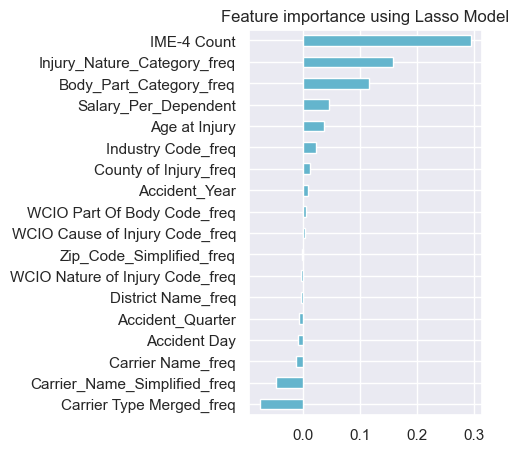

In [166]:
plot_importance(coef,'Lasso')

Let's consider all the values above 0.015.

 ### 4.2.2. Recursive Feature Elimination - RFE <a class="anchor" id="sub_section_4_2_2"></a>

  [Back to 4.2. Numerical Features](#section_4_2)<br>
 

RFE is employed here to further validate the important features as identified by LASSO. By sequentially removing the least important features, RFE helps to refine the feature set.

The selected features after RFE likely overlap with those identified by LASSO, suggesting consistency in feature importance.
Using both LASSO and RFE provides a more robust feature selection by cross-validating the importance of individual features.

This block of code performs RFE to identify the best subset of features by iterating over a range of feature numbers. The code aims to maximize model performance on the validation set.

In [167]:
# RFE using Logistic Regression
model = LogisticRegression()

#Use the function defined in utils.py
best_features, best_score, scores = find_optimal_features_with_rfe(
    model, 
    X_train_num_scaled, 
    y_train_encoded, 
    X_val_num_scaled, 
    y_val_encoded,
    max_features=19
)

Optimum number of features: 13
F1 Macro Score with 13 features: 0.556608



The loop evaluates models with 1 to 18 features, tracking the score for each.

The output indicates that 17 features yielded the highest validation f1_score score of 0.702260.

**Applying RFE with the Optimal Number of Features**

Once the optimal number of features is identified, the RFE model is finalized with this configuration.

In [168]:
#rfscv- to select 1st the number of features we should select
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 13)

In [169]:
X_rfe= rfe.fit_transform(X=X_train_num_scaled, y=y_train_encoded)

This shows the results of the feature selection process, listing the features selected by RFE. The code snippet confirms which features were selected as relevant by the RFE model and displays them in a boolean Series, where True indicates the feature was selected and False means it was not.

In [170]:
selected_features = pd.Series(rfe.support_, index = X_train_num_scaled.columns)
selected_features

Age at Injury                       True
IME-4 Count                         True
Accident_Quarter                   False
Accident_Year                       True
Accident Day                       False
Salary_Per_Dependent                True
Carrier_Name_Simplified_freq        True
Zip_Code_Simplified_freq           False
Industry Code_freq                  True
County of Injury_freq              False
District Name_freq                  True
WCIO Cause of Injury Code_freq      True
WCIO Nature of Injury Code_freq    False
WCIO Part Of Body Code_freq         True
Carrier Name_freq                   True
Body_Part_Category_freq             True
Injury_Nature_Category_freq         True
Carrier Type Merged_freq            True
dtype: bool

### 4.2.3. Feature Importance - Decision Tree <a class="anchor" id="sub_section_4_2_3"></a>
 [Back to 4.2. Numerical Features](#section_4_2)<br>



In [93]:
from utils import compare_feature_importances

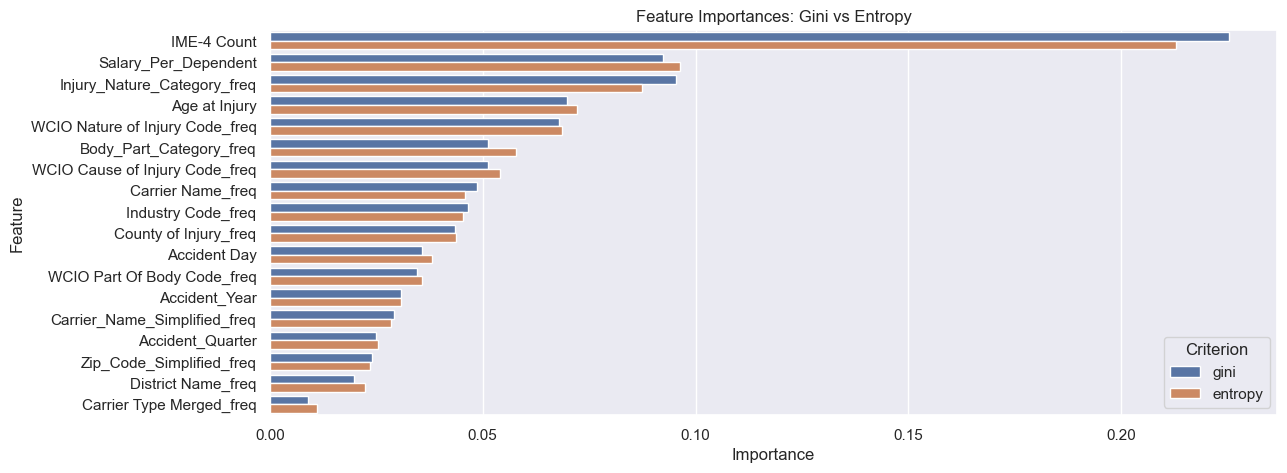

       gini   entropy               col
0  0.069724  0.072102     Age at Injury
1  0.225335  0.212854       IME-4 Count
2  0.024945  0.025438  Accident_Quarter
3  0.030862  0.030756     Accident_Year
4  0.035725  0.038154      Accident Day


In [172]:
# Call the function with your training data
zippy = compare_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(zippy.head())

### 4.2.4. Feature Importance - Random Forest <a class="anchor" id="sub_section_4_2_4"></a>

 [Back to 4.2. Numerical Features](#section_4_2)<br>


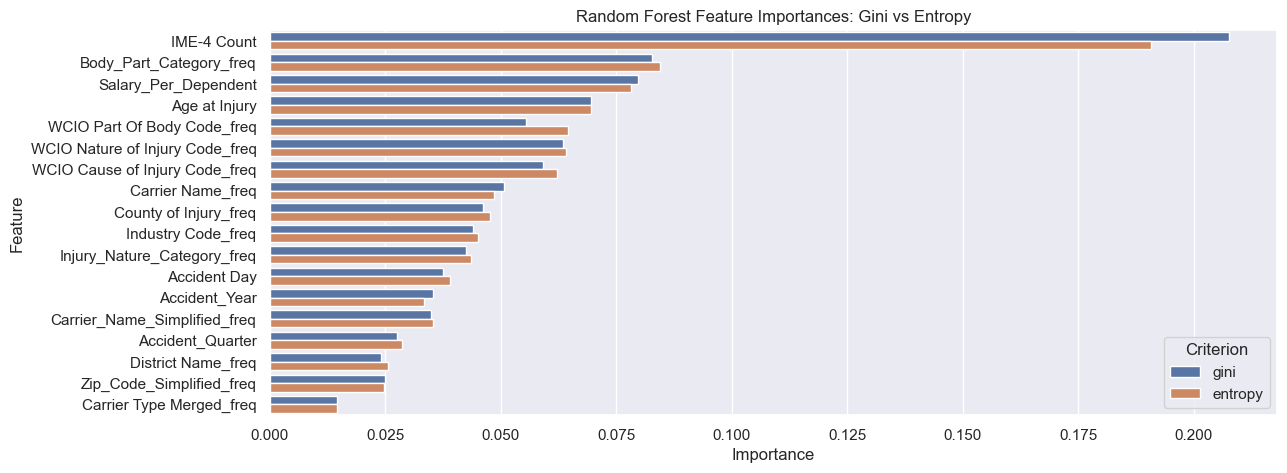

       gini   entropy               col
0  0.069522  0.069450     Age at Injury
1  0.207660  0.190671       IME-4 Count
2  0.027573  0.028659  Accident_Quarter
3  0.035412  0.033335     Accident_Year
4  0.037557  0.038974      Accident Day


In [173]:
# Call the function with your training data
importances = compare_rf_feature_importances(X_train_num_scaled, y_train_encoded)

# Access the DataFrame for further analysis if needed
print(importances.head())

## 4.3. Categorical Features</b> <a class="anchor" id="section_4_3"></a>
[Back to 4. Feature Selection](#chapter4)<br>

Chi-squared and MIC for the categorical ones.

In [174]:
X_train_mic_chi2 = X_train_min[feature_categories['categorical'] + feature_categories['binary']]

In [175]:
X_train_mic_chi2.shape

(107552, 11)

In [176]:
X_train_mic_chi2.columns

Index(['Income_Category', 'Age Group', 'promptness_category',
       'promptness_C2_category', 'promptness_C3_category', 'Industry Risk',
       'Gender_M', 'Gender_U', 'Medical Fee Region_II',
       'Medical Fee Region_III', 'Medical Fee Region_UK'],
      dtype='object')

 ### 4.3.1. $\chi ^2$ Test for Independence <a class="anchor" id="sub_section_4_3_1"></a>

[Back to 4.3. Categorical Features](#section_4_3)<br>


The Chi-squared test helps us identify the most relevant categorical and binary features by evaluating their independence with the target variable. 

In [177]:
from utils import select_high_score_features_chi2_no_model

In [178]:
# Example usage
high_score_features_chi2, scores = select_high_score_features_chi2_no_model(
    X_train_mic_chi2, 
    y_train_encoded, 
    threshold=6
)

Top 6 features based on Chi-square scores: ['Income_Category', 'promptness_category', 'promptness_C3_category', 'promptness_C2_category', 'Age Group', 'Gender_M']
Corresponding Chi-square scores: [4085.7702159094783, 3654.8210723613965, 2402.2981176345606, 2078.612526842703, 1047.8796398936452, 442.26704494222025]


In [179]:
high_score_features_chi2

['Income_Category',
 'promptness_category',
 'promptness_C3_category',
 'promptness_C2_category',
 'Age Group',
 'Gender_M']

 ### 4.3.2. Mutual Information Criterion (MIC) <a class="anchor" id="sub_section_4_3_2"></a>

 [Back to 4.3. Categorical Features](#section_4_3)<br>
 

The Mutual Information Criterion is used to measure the dependence between each feature and the target variable. By setting a threshold, we retain only the most relevant features.

In [180]:
from utils import select_high_score_features_MIC

In [181]:
# Example usage
high_score_features_MIC, scores_MIC = select_high_score_features_MIC(
    X_train_mic_chi2, 
    y_train_encoded, 
    threshold=6, 
    random_state=42)

Top 6 features based on MIC scores: ['promptness_C2_category', 'Income_Category', 'promptness_C3_category', 'promptness_category', 'Age Group', 'Industry Risk']
Corresponding MIC scores: [0.1404565324044249, 0.10257036425247557, 0.0878432575702559, 0.0541768325828369, 0.016374713136428687, 0.009252066633843148]


In [182]:
X_train_mic_chi2.shape

(107552, 11)

In [183]:
high_score_features_MIC

['promptness_C2_category',
 'Income_Category',
 'promptness_C3_category',
 'promptness_category',
 'Age Group',
 'Industry Risk']

**Intersection of Selected Features by Chi-squared and MIC** <br>
To identify the most relevant categorical features, we take the intersection of features selected by both Chi-squared and MIC methods.

In [184]:
# Find common features between Chi-squared and MIC selections
common_categorical_features = list(set(high_score_features_chi2).intersection(set(high_score_features_MIC)))
features_selected = common_categorical_features  # Final list of selected features
features_selected  # Display the list of intersected features

['promptness_C3_category',
 'Age Group',
 'promptness_C2_category',
 'Income_Category',
 'promptness_category']

## 4.4. Final Features</b> <a class="anchor" id="section_4_4"></a>
[Back to 4. Feature Selection](#chapter4)<br>

The following table evaluates all numerical features using multiple feature selection techniques: Spearman Correlation, LASSO Regression, RFE, Decision Tree, and Random Forest. Based on these combined insights, a final decision is provided in the "What to do?" column.
Here is the updated table based on the latest results from **LASSO**, **RFE**, **Decision Tree Importance**, and **Random Forest Importance**:


| **Predictor**                 | **LASSO**         | **RFE**            | **Decision Tree Importance**   | **Random Forest Importance**  | **What to do?**               |
|-------------------------------|-------------------|--------------------|--------------------------------|--------------------------------|--------------------------------|
| IME-4 Count                   | Keep              | Keep               | Keep                           | Keep                           | Include                       |
| Injury_Nature_Category_freq   | Keep              | Keep               | Keep                           | Discard                        | Include                       |
| Body_Part_Category_freq       | Keep              | Keep               | Discard                        | Keep                           | Include                       |
| Salary_Per_Dependent          | Keep              | Keep               | Keep                           | Keep                           | Include                       |
| Age at Injury                 | Keep              | Keep               | Keep                           | Keep                           | Include                       |
| Industry Code_freq            | Discard              | Keep               | Discard                        | Discard                        | Discard              |
| Accident_Year                 | Discard              | Keep               | Discard                        | Discard                        | Discard             |
| Carrier_Name_Simplified_freq  | Keep           | Keep            | Discard                        | Discard                        | Consider Include                        |
| District Name_freq            | Discard           | Keep            | Discard                        | Discard                        | Discard                       |
| Accident_Quarter              | Discard           | Discard               | Discard                        | Discard                        | Discard                       |
| Accident Day                  | Discard           | Discard               | Discard                        | Discard                        | Discard                       |
| Zip_Code_Simplified_freq      | Discard           | Discard            | Discard                        | Discard                        | Discard                       |
| WCIO Cause of Injury Code_freq| Discard           | Keep               | Keep                        | Discard                        | Consider Include                        |
| WCIO Part Of Body Code_freq   | Discard           | Keep            | Keep                        | Discard                        | Consider Include                        |
| WCIO Nature of Injury Code_freq| Discard           | Discard           | Keep                        | Keep                        | Consider Include                        |
| Carrier Type Merged_freq      | Keep           | Keep               | Discard                        | Discard                        | Consider Include                        |
| Carrier Name_freq             | Discard           | Keep            | Discard                        | Discard                        | Discard                       |
| County of Injury_freq         | Discard           | Discard            | Discard                        | Discard                        | Discard                       |


### **Categorical Feature Selection Results**

The following table summarizes the decisions for each categorical feature based on **Mutual Information (MIC)** and **Chi-Squared** (X²) results. The retained features will be used in subsequent modeling to enhance predictive performance.

| **Feature**              | **X² Results**          | **MIC Results**         | **Decision**               |
|---------------------------|-------------------------|-------------------------|----------------------------|
| promptness_C2_category | Keep                  | Keep                  | Include               |
| promptness_category    | Keep                 | Keep                       | Include                |
| promptness_C3_category | Keep                       | Keep                  | Include                |
| Age Group              | Keep                  | Keep                  | Include                |
| Income_Category        | Keep                  | Keep                 | Include                |
| Industry Risk         |    -                   |  -                 | Exclude                |
| Gender_M               | Keep                  | Keep                  | Include                |
| Gender_U               | -                       | -                       | Exclude          |
| Medical Fee Region_II  | -                       | -                       | Exclude               |
| Medical Fee Region_III | -                       | -                       | Exclude               |
| Medical Fee Region_UK  | -                       | -                       | Exclude                |


In [41]:
numerical_features

['Age at Injury',
 'IME-4 Count',
 'Accident_Quarter',
 'Accident_Year',
 'Accident Day',
 'Salary_Per_Dependent',
 'Carrier_Name_Simplified_freq',
 'Zip_Code_Simplified_freq',
 'Industry Code_freq',
 'County of Injury_freq',
 'District Name_freq',
 'WCIO Cause of Injury Code_freq',
 'WCIO Nature of Injury Code_freq',
 'WCIO Part Of Body Code_freq',
 'Carrier Name_freq',
 'Body_Part_Category_freq',
 'Injury_Nature_Category_freq',
 'Carrier Type Merged_freq']

In [185]:
final_features = [
    # Categorical features selected through MIC and chi2
    'promptness_C3_category','Age Group',
    'promptness_C2_category','Income_Category','promptness_category',
    # Important numerical features
    'IME-4 Count', 'Injury_Nature_Category_freq',  'Body_Part_Category_freq', 'Salary_Per_Dependent', 'Age at Injury']

final_features_consider = [
    # Categorical features selected through MIC and chi2
    'promptness_C3_category','Age Group','Gender_M',
    'promptness_C2_category','Income_Category','promptness_category',
    # Important numerical features
    'Injury_Nature_Category_freq', 'Body_Part_Category_freq',
    'IME-4 Count', 'Injury_Nature_Category_freq',  'Body_Part_Category_freq', 'Salary_Per_Dependent', 'Age at Injury',
    'WCIO Cause of Injury Code_freq','WCIO Part Of Body Code_freq', 'WCIO Nature of Injury Code_freq', 'Carrier Type Merged_freq', 'Carrier_Name_Simplified_freq'
    ]

# Extracting the final features from the processed datasets
X_train_final = X_train_min[final_features]
X_val_final = X_val_min[final_features]
X_test_final = df_test[final_features]

# Extracting the final features from the processed datasets
X_train_final_consider = X_train_min[final_features_consider]
X_val_final_consider = X_val_min[final_features_consider]
X_test_final_consider = df_test[final_features_consider]

# Print the shape of the final datasets to confirm consistency
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val_final shape: {X_val_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

X_train_final shape: (107552, 10)
X_val_final shape: (26887, 10)
X_test_final shape: (387975, 10)


In [186]:
len(y_train_encoded)

107552

In [187]:
len(y_val_encoded)

26887

# 5. Modelling <a class="anchor" id="chapter5"></a>
[Back to ToC](#toc)<br>

In this section, we focus on predicting the minority classes in our dataset. Since minority class prediction is often challenging due to imbalanced data, we prioritize models that handle such scenarios effectively. The chosen models include ensemble techniques like Random Forest and Gradient Boosting, known for their robustness in classification tasks, along with specialized algorithms like CatBoost and LightGBM, which are designed to handle categorical data efficiently and provide strong performance on imbalanced datasets.

## 5.1. Simple Models </b> <a class="anchor" id="section_5_1"></a>

[Back to 5. Modelling](#chapter5)<br>

Simple models serve as the foundation for understanding the problem and establishing a baseline for performance. These algorithms are straightforward to implement and interpret, making them ideal for initial evaluations, even in imbalanced datasets. In this section, we explore Logistic Regression, Decision Trees, and K-Nearest Neighbors (KNN) classifiers.


### 5.1.1. Logistic Regression <a class="anchor" id="sub_section_5_1_1"></a>

[Back to 5.1. Simple Models](#section_5_1)<br>

Logistic Regression is a simple yet effective model for binary classification tasks. While not tailored for imbalanced datasets, it serves as a baseline to compare more sophisticated methods. while Logistic Regression might not be ideal for imbalanced data, it’s included in the analysis to serve as a benchmark and provide a simple, interpretable comparison point.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      9980
           1       0.69      0.83      0.76     55125
           2       0.70      0.58      0.63     38624
           3       0.50      0.08      0.14      3823

    accuracy                           0.69    107552
   macro avg       0.65      0.52      0.55    107552
weighted avg       0.69      0.69      0.68    107552

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------

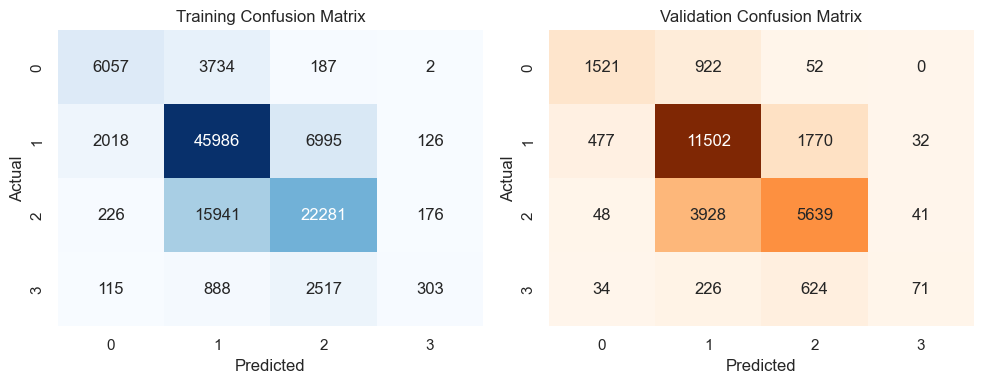

Time taken to run the cell: 11.35 seconds


In [188]:
# Record the start time
start_time = time.time()

lr_model = LogisticRegression(random_state=42, max_iter=500)

# Fit the model to the training data
lr_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_lr_train = lr_model.predict(X_train_final)
y_pred_lr_val = lr_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_lr_train, y_val_encoded, y_pred_lr_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


Although the F1 score is lower, it is evident that including class weights effectively mitigates the overfitting issue. Moving forward, we will incorporate class weights into the subsequent models to address class imbalance and improve generalization.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.73      0.60      0.66      9980
           1       0.70      0.83      0.76     55125
           2       0.70      0.60      0.65     38624
           3       0.51      0.10      0.16      3823

    accuracy                           0.70    107552
   macro avg       0.66      0.53      0.56    107552
weighted avg       0.70      0.70      0.69    107552

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------

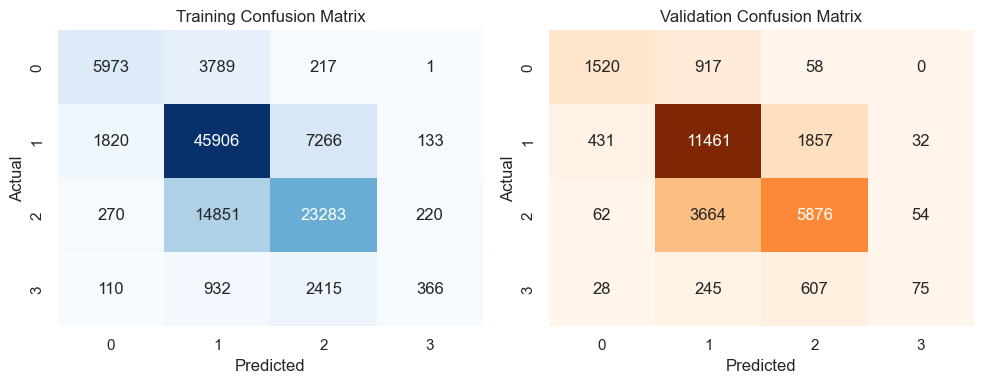

Time taken to run the cell: 10.25 seconds


In [189]:
# Record the start time
start_time = time.time()

lr_model = LogisticRegression(random_state=42, max_iter=500)

# Fit the model to the training data
lr_model.fit(X_train_final_consider, y_train_encoded)

# Predict on the training and validation data
y_pred_lr_train = lr_model.predict(X_train_final_consider)
y_pred_lr_val = lr_model.predict(X_val_final_consider)

# Evaluate the model
metrics(y_train_encoded, y_pred_lr_train, y_val_encoded, y_pred_lr_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


### 5.1.2. Decision Trees <a class="anchor" id="sub_section_5_1_2"></a>

[Back to 5.1. Simple Models](#section_5_1)<br>

Decision Trees are intuitive models that split the data into branches based on feature thresholds, making decisions that optimize classification purity at each step. They handle imbalanced datasets better with adjustments such as class weights.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      9980
           1       1.00      0.99      0.99     55125
           2       1.00      1.00      1.00     38624
           3       1.00      1.00      1.00      3823

    accuracy                           0.99    107552
   macro avg       0.99      1.00      0.99    107552
weighted avg       0.99      0.99      0.99    107552

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------

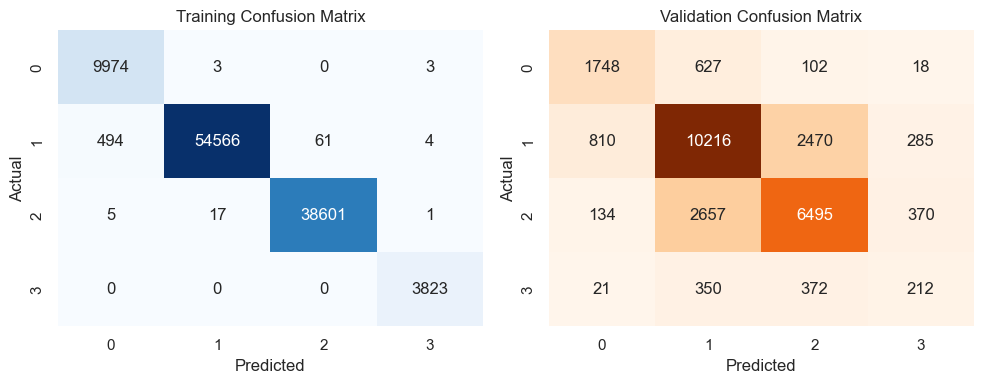

Time taken to run the cell: 2.62 seconds


In [190]:
from sklearn.tree import DecisionTreeClassifier
import time

# Record the start time
start_time = time.time()

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Fit the model to the training data
dt_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_dt_train = dt_model.predict(X_train_final)
y_pred_dt_val = dt_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_dt_train, y_val_encoded, y_pred_dt_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

In this scenario, overfitting remains an issue. To address this, we can manually adjust the class weights to mitigate its effects, ensuring the model places more emphasis on the minority classes during training. This approach involves assigning higher weights to underrepresented classes and lower weights to overrepresented ones. Below is the process for adding manual class weights:

In [191]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute the normal class weights
classes = np.unique(y_train_encoded)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_encoded)
class_weights_dict = dict(zip(classes, class_weights))

# Print the computed class weights
print("Computed Class Weights:")
print(class_weights_dict)

Computed Class Weights:
{0: 2.694188376753507, 1: 0.48776417233560093, 2: 0.6961474730737366, 3: 7.03321998430552}


In [192]:
manual_class_weights = {
    '0': 10, 
    '1': 0.63, 
    '2': 0.89,     
}

# Get unique classes in y_train_encoded
unique_classes = list(set(y_train_encoded))

# Ensure class weights only include keys for existing classes
adjusted_class_weights = {k: manual_class_weights[k] for k in unique_classes if k in manual_class_weights}

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9980
           1       1.00      1.00      1.00     55125
           2       1.00      1.00      1.00     38624
           3       1.00      1.00      1.00      3823

    accuracy                           1.00    107552
   macro avg       1.00      1.00      1.00    107552
weighted avg       1.00      1.00      1.00    107552

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------

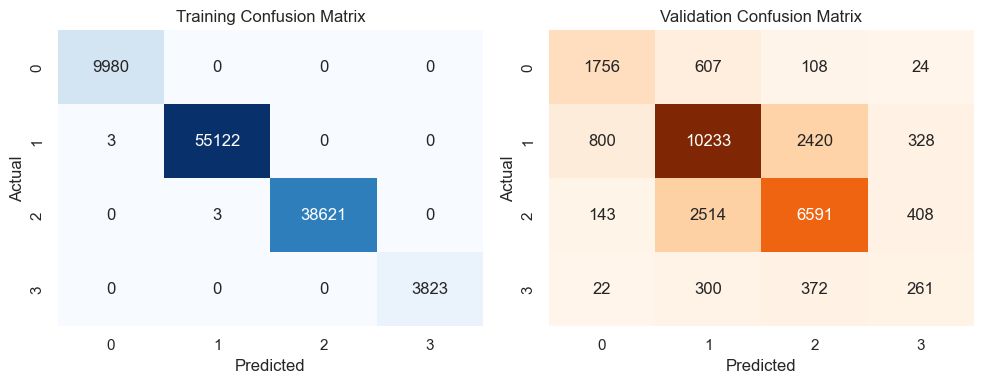

Time taken to run the cell: 3.18 seconds


In [193]:
# Record the start time
start_time = time.time()

# Initialize the Decision Tree model with manual class weights
dt_model_class = DecisionTreeClassifier(random_state=42, class_weight=adjusted_class_weights)

# Fit the model to the training data
dt_model_class.fit(X_train_final_consider, y_train_encoded)

# Predict on the training and validation data
y_pred_dt_train_class = dt_model_class.predict(X_train_final_consider)
y_pred_dt_val_class = dt_model_class.predict(X_val_final_consider)

# Evaluate the model
metrics(y_train_encoded, y_pred_dt_train_class, y_val_encoded, y_pred_dt_val_class)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


**Grid Search**

Grid Search is a systematic method for hyperparameter tuning in machine learning models. It tests all possible combinations of specified hyperparameters to find the configuration that yields the best performance on a given validation metric. The process involves:

Defining a parameter grid with potential values for each hyperparameter.
Evaluating the model's performance using cross-validation for every parameter combination.
Selecting the best combination based on a scoring metric (e.g., accuracy, F1-score).
While Grid Search can be computationally expensive, it ensures that the best hyperparameter combination is selected systematically.

In [194]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import time

# Define the parameter grid for Grid Search
param_grid = {
    'max_depth': [3, 5, 10, 15,  None],         # Tree depth
    'min_samples_split': [2, 5, 10, 15, 30],      # Minimum samples required to split
    'min_samples_leaf': [1, 2, 5, 10, 15, 30]       # Minimum samples required at a leaf node
}

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, class_weight=adjusted_class_weights)

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='f1_macro',  # Scoring metric
    cv=5,                # Number of folds in cross-validation
    n_jobs=-1,           # Use all available CPUs
    verbose=1            # Display progress
)

# Record the start time
start_time = time.time()

# Fit Grid Search to the training data
grid_search.fit(X_train_final_consider, y_train_encoded)

# Record the end time
end_time = time.time()

# Output the best parameters and corresponding score
print("Best Parameters:", grid_search.best_params_)
print(f"Best F1-Score: {grid_search.best_score_:.4f}")
print(f"Time taken for Grid Search: {end_time - start_time:.2f} seconds")

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 30, 'min_samples_split': 2}
Best F1-Score: 0.6624
Time taken for Grid Search: 173.99 seconds


In [195]:
dt_best_model = grid_search.best_estimator_

Metrics for Decision Tree (Training and Validation):
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.66      0.76      9980
           1       0.82      0.85      0.83     55125
           2       0.77      0.83      0.80     38624
           3       0.61      0.27      0.37      3823

    accuracy                           0.80    107552
   macro avg       0.77      0.65      0.69    107552
weighted avg       0.80      0.80      0.80    107552

___________________________________________________________________________________________________________
                                                VALIDATION                      

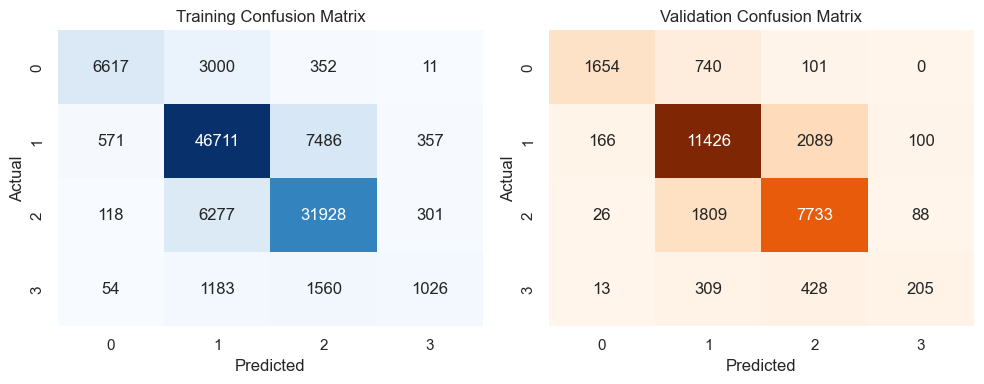

In [196]:
# Fit the model with the best parameters to the training data
dt_best_model.fit(X_train_final_consider, y_train_encoded)

# Predict on the training and validation datasets
y_pred_dt_train = dt_best_model.predict(X_train_final_consider)
y_pred_dt_val = dt_best_model.predict(X_val_final_consider)

# Evaluate the performance using metrics function
print("Metrics for Decision Tree (Training and Validation):")
metrics(y_train_encoded, y_pred_dt_train, y_val_encoded, y_pred_dt_val)

### 5.1.3. K-Nearest Neighbors (KNN) <a class="anchor" id="sub_section_5_1_3"></a>

[Back to 5.1. Simple Models](#section_5_1)<br>


KNN is a distance-based algorithm that predicts the class of a data point by considering the majority class among its nearest neighbors. It is sensitive to class imbalance, so preprocessing like scaling and balancing techniques are essential for effective results.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      9980
           1       0.81      0.86      0.84     55125
           2       0.79      0.80      0.80     38624
           3       0.70      0.19      0.29      3823

    accuracy                           0.80    107552
   macro avg       0.79      0.64      0.67    107552
weighted avg       0.80      0.80      0.80    107552

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------

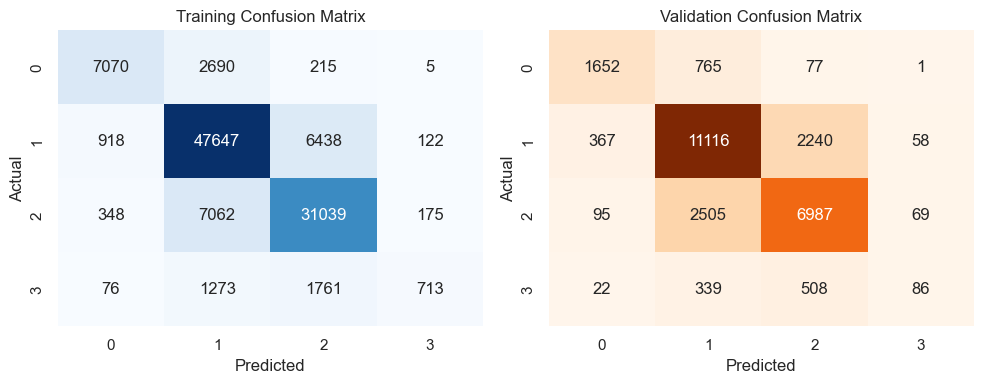

Time taken to run the cell: 65.00 seconds


In [197]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time

# Record the start time
start_time = time.time()

# Create a pipeline with StandardScaler and KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('knn', KNeighborsClassifier(n_neighbors=5))  # Initialize KNN
])

# Fit the pipeline to the training data
knn_pipeline.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_knn_train = knn_pipeline.predict(X_train_final)
y_pred_knn_val = knn_pipeline.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_knn_train, y_val_encoded, y_pred_knn_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.70      0.75      9980
           1       0.79      0.88      0.83     55125
           2       0.80      0.76      0.78     38624
           3       0.76      0.19      0.31      3823

    accuracy                           0.80    107552
   macro avg       0.79      0.63      0.67    107552
weighted avg       0.80      0.80      0.79    107552

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------

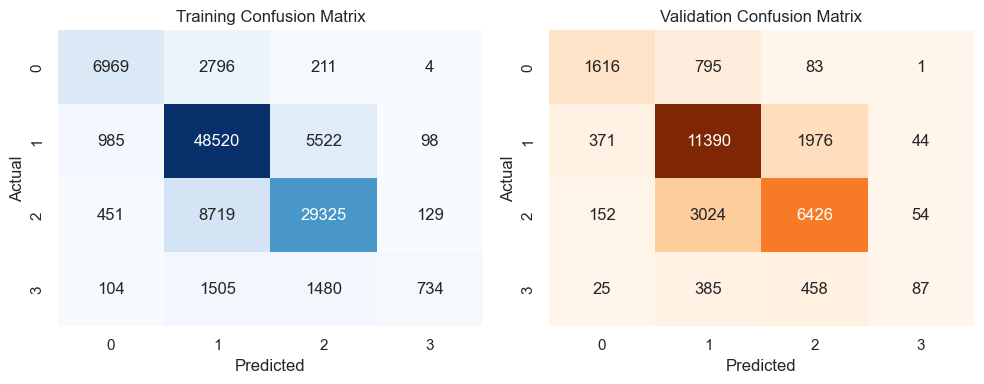

Time taken to run the cell: 39.39 seconds


In [198]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time

# Record the start time
start_time = time.time()

# Create a pipeline with StandardScaler and KNN
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('knn', KNeighborsClassifier(n_neighbors=5))  # Initialize KNN
])

# Fit the pipeline to the training data
knn_pipeline.fit(X_train_final_consider, y_train_encoded)

# Predict on the training and validation data
y_pred_knn_train = knn_pipeline.predict(X_train_final_consider)
y_pred_knn_val = knn_pipeline.predict(X_val_final_consider)

# Evaluate the model
metrics(y_train_encoded, y_pred_knn_train, y_val_encoded, y_pred_knn_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

In [65]:
# best_knn = grid_search.best_estimator_

## 5.2. Deep Learning Methods</b> <a class="anchor" id="section_5_2"></a>
[Back to 5. Modelling](#chapter5)<br>

Deep learning methods are powerful tools for capturing complex and non-linear relationships in data. These models are particularly useful for large datasets with intricate patterns, but they require careful tuning to avoid overfitting, especially in imbalanced datasets like ours. One advantage of neural networks is their flexibility to model interactions between features automatically, but they also demand more computational resources and expertise in fine-tuning.

Here, we explore a simple feed-forward neural network implemented using the TensorFlow library. To address the imbalance issue in the dataset, we'll apply class weights during training, ensuring that the minority classes are properly accounted for.

A feed-forward neural network is one of the most basic forms of neural networks. It consists of input layers, hidden layers with activation functions, and an output layer for predictions. This structure makes it versatile and applicable to binary or multi-class classification problems.

In [199]:
# import tensorflow as tf
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
# import time

# # Define the model
# def create_model_with_manual_weights(input_dim):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(64, activation='relu', input_dim=input_dim),
#         tf.keras.layers.Dropout(0.3),  # Regularization
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(len(manual_class_weights), activation='softmax')  # Output layer for multi-class
#     ])
#     model.compile(
#         optimizer='adam',
#         loss='sparse_categorical_crossentropy',  # Suitable for integer labels
#         metrics=['accuracy']
#     )
#     return model

# # Record the start time
# start_time = time.time()

# # Initialize the model
# input_dim = X_train_final.shape[1]
# nn_model_manual_weights = create_model_with_manual_weights(input_dim)

# # Train the model with corrected manual class weights
# nn_model_manual_weights.fit(
#     X_train_final,
#     y_train_encoded,
#     validation_data=(X_val_final, y_val_encoded),
#     epochs=30,
#     batch_size=64,
#     verbose=1
# )

# # Record the end time
# end_time = time.time()
# print(f"Time taken to train the model: {end_time - start_time:.2f} seconds")

# # Predict on training and validation data
# y_pred_nn_train_manual = np.argmax(nn_model_manual_weights.predict(X_train_final), axis=1)
# y_pred_nn_val_manual = np.argmax(nn_model_manual_weights.predict(X_val_final), axis=1)

# # Evaluate using the metrics() function
# print("\nMetrics for Neural Network:")
# metrics(y_train_encoded, y_pred_nn_train_manual, y_val_encoded, y_pred_nn_val_manual)

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\xandg\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\xandg\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\xandg\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "c:\Users\xandg\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "c:\Users\xandg\anaconda3\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\xandg\AppData\Local\Temp\ipykernel_15996\1053189219.py", line 29, in <module>
      nn_model_manual_weights.fit(
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 1 1 1 2 1 1 2 2 2 2 2 2 2 1 1 1 2 2 2 3 1 0 1 1 2 1 2 2 1 1 2 1 1 1 1 2 2 1 2 1 1 1 1 2 1 2 1 1 1 2 1 1 2 2 1 1 3 1 1 1 2 1 1 1
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_556918]

In [ ]:
# import tensorflow as tf
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np
# import time

# # Define the model
# def create_model_with_manual_weights(input_dim):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(64, activation='relu', input_dim=input_dim),
#         tf.keras.layers.Dropout(0.3),  # Regularization
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.Dense(len(manual_class_weights), activation='softmax')  # Output layer for multi-class
#     ])
#     model.compile(
#         optimizer='adam',
#         loss='sparse_categorical_crossentropy',  # Suitable for integer labels
#         metrics=['accuracy']
#     )
#     return model

# # Record the start time
# start_time = time.time()

# # Initialize the model
# input_dim = X_train_final_consider.shape[1]
# nn_model_manual_weights = create_model_with_manual_weights(input_dim)

# # Train the model with corrected manual class weights
# nn_model_manual_weights.fit(
#     X_train_final_consider,
#     y_train_encoded,
#     validation_data=(X_val_final_consider, y_val_encoded),
#     epochs=30,
#     batch_size=64,
#     verbose=1
# )

# # Record the end time
# end_time = time.time()
# print(f"Time taken to train the model: {end_time - start_time:.2f} seconds")

# # Predict on training and validation data
# y_pred_nn_train_manual = np.argmax(nn_model_manual_weights.predict(X_train_final_consider), axis=1)
# y_pred_nn_val_manual = np.argmax(nn_model_manual_weights.predict(X_val_final_consider), axis=1)

# # Evaluate using the metrics() function
# print("\nMetrics for Neural Network:")
# metrics(y_train_encoded, y_pred_nn_train_manual, y_val_encoded, y_pred_nn_val_manual)

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\xandg\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "c:\Users\xandg\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\xandg\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "c:\Users\xandg\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "c:\Users\xandg\anaconda3\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "c:\Users\xandg\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\xandg\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\xandg\AppData\Local\Temp\ipykernel_15996\357119022.py", line 29, in <module>
      nn_model_manual_weights.fit(
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\xandg\anaconda3\Lib\site-packages\keras\src\backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 1 2 1 1 1 2 1 2 3 1 1 0 1 1 0 1 1 1 2 2 3 2 1 1 2 2 1 1 2 1 3 2 1 1 2 1 2 2 1 2 1 2 1 0 2 1 2 2 2 1 2 1 2 1 1 1 1 2 1 1 2 0 2 1
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_557955]

## 5.3. Ensemble Models </b> <a class="anchor" id="section_5_3"></a>

[Back to 5. Modelling](#chapter5)<br>

Ensemble models combine predictions from multiple base models to improve performance. These methods are robust to overfitting and perform well on imbalanced datasets when combined with appropriate class balancing techniques.

### 5.3.1. Bagging <a class="anchor" id="sub_section_5_3_1"></a>

[Back to 5.3. Ensemble Models](#section_5_3)<br>

Bagging methods, such as Random Forest, aggregate predictions from multiple models trained on bootstrap samples. This reduces variance and enhances generalization.
Random Forest is an ensemble learning method that builds multiple decision trees and averages their predictions. It can handle imbalanced datasets relatively well by adjusting class weights.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      9980
           1       1.00      0.99      1.00     55125
           2       1.00      1.00      1.00     38624
           3       1.00      1.00      1.00      3823

    accuracy                           1.00    107552
   macro avg       0.99      1.00      0.99    107552
weighted avg       1.00      1.00      1.00    107552

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------

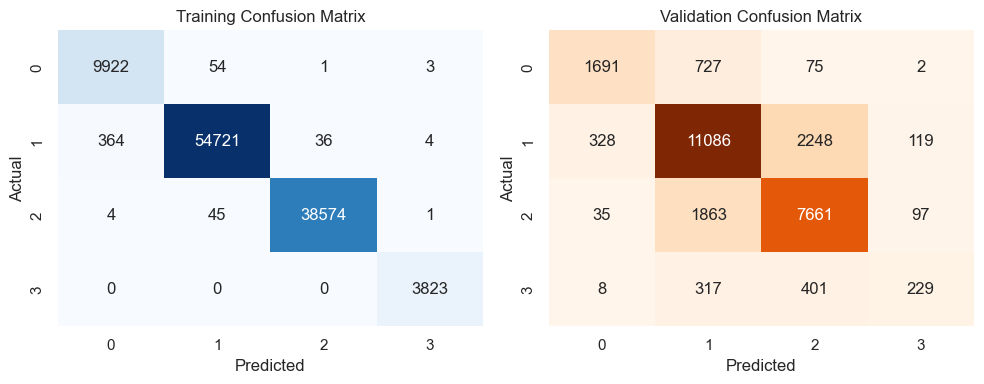

Time taken to run the cell: 42.99 seconds


In [201]:
# Record the start time
start_time = time.time()

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Fit the model to the training data
rf_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_rf_train = rf_model.predict(X_train_final)
y_pred_rf_val = rf_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_rf_train, y_val_encoded, y_pred_rf_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


The Random Forest model, even with the use of class_weight='balanced', continues to show signs of overfitting. This indicates that while class weights have helped mitigate class imbalance to some extent, additional hyperparameter tuning is required to achieve a better balance between performance on the training and validation sets. To address this, we will implement a Grid Search approach, incorporating different combinations of hyperparameters and testing additional manually computed class weights to find the best configuration.

### 5.3.2. Boosting <a class="anchor" id="sub_section_5_3_2"></a>

[Back to 5.3. Ensemble Models](#section_5_3)<br>

Boosting methods, including XGBoost, LightGBM, and CatBoost, sequentially train models to correct errors from previous iterations. These are powerful tools for imbalanced datasets due to their ability to focus on harder-to-classify examples.


#### **XGBoost**

XGBoost is a gradient boosting algorithm that is highly effective for classification tasks, especially on imbalanced datasets. It uses regularization to reduce overfitting and improve generalization.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.69      0.79      9980
           1       0.83      0.86      0.84     55125
           2       0.79      0.85      0.82     38624
           3       0.71      0.39      0.50      3823

    accuracy                           0.82    107552
   macro avg       0.82      0.69      0.74    107552
weighted avg       0.82      0.82      0.82    107552

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------

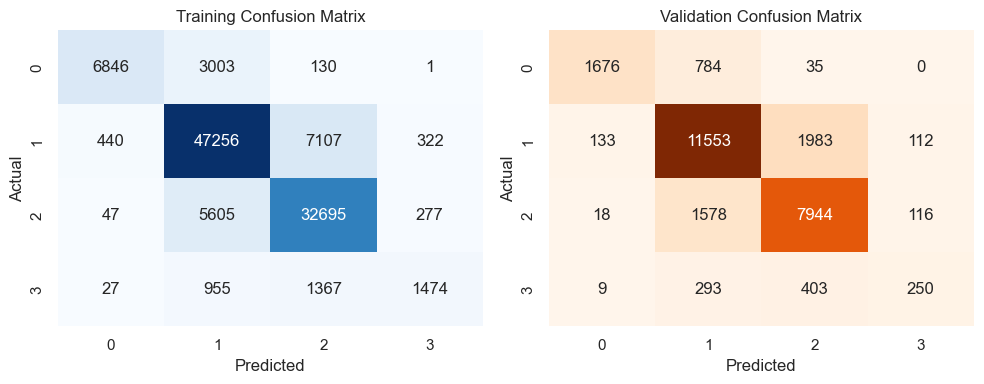

Time taken to run the cell: 15.69 seconds


In [202]:
# Initialize the XGBoost model
from xgboost import XGBClassifier

# Record the start time
start_time = time.time()

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

# Fit the model to the training data
xgb_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_xgb_train = xgb_model.predict(X_train_final)
y_pred_xgb_val = xgb_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_xgb_train, y_val_encoded, y_pred_xgb_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

In [205]:
# Initialize the XGBoost model
from xgboost import XGBClassifier

# Record the start time
start_time = time.time()

xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

# Fit the model to the training data
xgb_model.fit(X_train_final_consider, y_train_encoded)

# Predict on the training and validation data
y_pred_xgb_train = xgb_model.predict(X_train_final_consider)
y_pred_xgb_val = xgb_model.predict(X_val_final_consider)

# Evaluate the model
metrics(y_train_encoded, y_pred_xgb_train, y_val_encoded, y_pred_xgb_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")

XGBoostError: [03:36:57] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\data\array_interface.h:218: Check failed: m == 1 || n == 1: 

**SMOTE**

To effectively address class imbalance, we combine different over-sampling techniques, such as SMOTE (for numerical features), SMOTENC (for mixed features), ADASYN (Adaptive Synthetic Sampling), and Borderline-SMOTE (a variant focused on borderline cases). These resampling methods are integrated into an XGBoost pipeline with Grid Search for hyperparameter optimization.

The key steps involve:

Defining Sampling Strategies: Including 'minority', 'not minority', 'not majority', and 'auto'.
Integrating Resampling Methods:
- SMOTE
- SMOTENC
- ADASYN
- Borderline-SMOTE
- Hyperparameter Grid Search: Optimize XGBoost parameters like learning_rate and n_estimators for each sampling technique.
- Evaluation: Use F1-Score (macro average) as the scoring metric and evaluate performance across different resampling methods.

In [204]:
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE
from imblearn.pipeline import Pipeline  # Import Pipeline from imblearn
from xgboost import XGBClassifier

categorical_indices = X_train_final.columns

# Scoring metric
f1_macro = make_scorer(f1_score, average='macro')

# Define XGBoost classifier
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

# Sampling strategies
sampling_strategies = ['minority', 'not minority', 'not majority', 'auto']

# Define resampling techniques
resampling_methods = {
    'SMOTE': SMOTE(random_state=42, n_jobs=-1),
    # 'SMOTENC': SMOTENC(categorical_features=categorical_indices, random_state=42),
    'ADASYN': ADASYN(random_state=42, n_jobs=-1),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42, n_jobs=-1)
}

# Parameter grid for XGBoost
param_grid = {
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [100, 200]
}

# Grid search results
results = []

# Grid Search Loop
print("Starting Grid Search with Resampling Methods...\n")
for resampling_name, resampler in resampling_methods.items():
    for sampling_strategy in sampling_strategies:
        print(f"Running {resampling_name} with sampling_strategy='{sampling_strategy}'...")
        
        # Record start time
        start_time = time.time()
        
        # Pipeline with resampling and model
        pipeline = Pipeline([
            ('sampling', resampler.set_params(sampling_strategy=sampling_strategy)),
            ('model', xgb_model)
        ])
        
        # Grid Search with Cross Validation
        grid_search = GridSearchCV(
            pipeline, param_grid, scoring=f1_macro, cv=3, verbose=1
        )
        grid_search.fit(X_train_final, y_train_encoded)
        
        # Record results
        results.append({
            'resampling_method': resampling_name,
            'sampling_strategy': sampling_strategy,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_
        })
        
        print(f"Time taken: {time.time() - start_time:.2f} seconds\n")

# Display the best result
best_result = max(results, key=lambda x: x['best_score'])
print("Best Result:")
print(best_result)

Starting Grid Search with Resampling Methods...

Running SMOTE with sampling_strategy='minority'...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Time taken: 209.49 seconds

Running SMOTE with sampling_strategy='not minority'...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Time taken: 221.26 seconds

Running SMOTE with sampling_strategy='not majority'...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Time taken: 213.42 seconds

Running SMOTE with sampling_strategy='auto'...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Time taken: 480.07 seconds

Running ADASYN with sampling_strategy='minority'...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Time taken: 218.13 seconds

Running ADASYN with sampling_strategy='not minority'...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Time taken: 763.95 seconds

Running ADASYN with sampling_strategy='not majority'...
Fitting 3 folds for each of 4 candidates, totalling

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      9980
           1       0.86      0.82      0.84     55125
           2       0.78      0.89      0.83     38624

    accuracy                           0.83    103729
   macro avg       0.86      0.79      0.82    103729
weighted avg       0.84      0.83      0.83    103729

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------

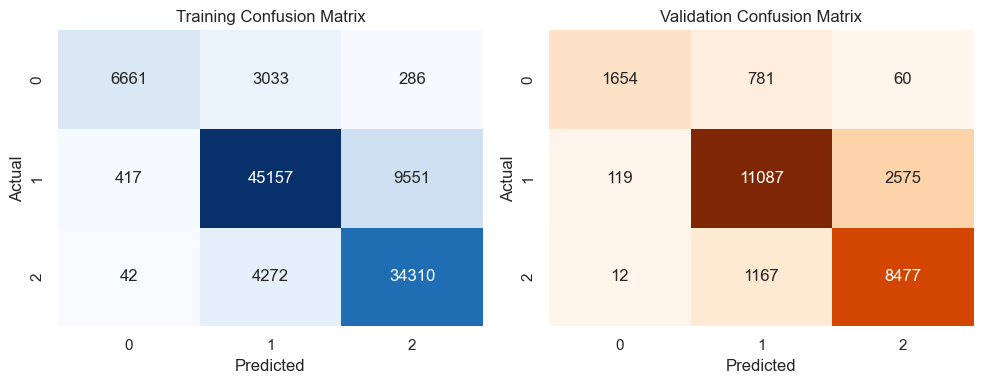


Time taken to retrain and evaluate the best model: 24.63 seconds


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import BorderlineSMOTE
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
import time

# Best parameters
best_params = {'learning_rate': 0.1, 'n_estimators': 200}
best_resampling = BorderlineSMOTE(sampling_strategy='not minority', random_state=42, n_jobs=-1)

# Define the pipeline with the best resampling method and XGBoost
pipeline = Pipeline([
    ('resampling', best_resampling),
    ('model', XGBClassifier(**best_params, random_state=42, eval_metric='logloss', use_label_encoder=False))
])

# Record the start time
start_time = time.time()

# Fit the pipeline on the training data
pipeline.fit(X_train_final, y_train_encoded)

# Predict on training and validation data
y_pred_train = pipeline.predict(X_train_final)
y_pred_val = pipeline.predict(X_val_final)

# Compute metrics
metrics(y_train_encoded, y_pred_train, y_val_encoded, y_pred_val)

# Record the end time
end_time = time.time()
print("\nTime taken to retrain and evaluate the best model: {:.2f} seconds".format(end_time - start_time))


In the current implementation, the XGBoost model shows promising results with a lower degree of overfitting compared to other models. However, there is still room for improvement, particularly in the performance of minority classes. To address this, we will perform a Grid Search to optimize the hyperparameters and improve the model's overall performance.

In [ ]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import time

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train_encoded)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1, 2, 5]  # Weight adjustment for class imbalance
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',  # Evaluate using F1-score
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Record the start time
start_time = time.time()

# Fit GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the grid search: {end_time - start_time:.2f} seconds")

# Display the best parameters and F1-score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best F1-Score: {grid_search.best_score_:.4f}")

# Evaluate the best model on the validation set
best_xgb_model = grid_search.best_estimator_
y_pred_xgb_val = best_xgb_model.predict(X_val_final)

# Evaluate metrics on the validation set
# Replace 'metrics' with the actual function you use for evaluation
metrics(y_train_encoded, best_xgb_model.predict(X_train_final), y_val_encoded, y_pred_xgb_val)

#### **LightGBM**

LightGBM is a gradient boosting framework designed for fast training and low memory usage. It works well with large datasets and can efficiently handle imbalanced data

  File "c:\Users\xandg\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 103729, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63   

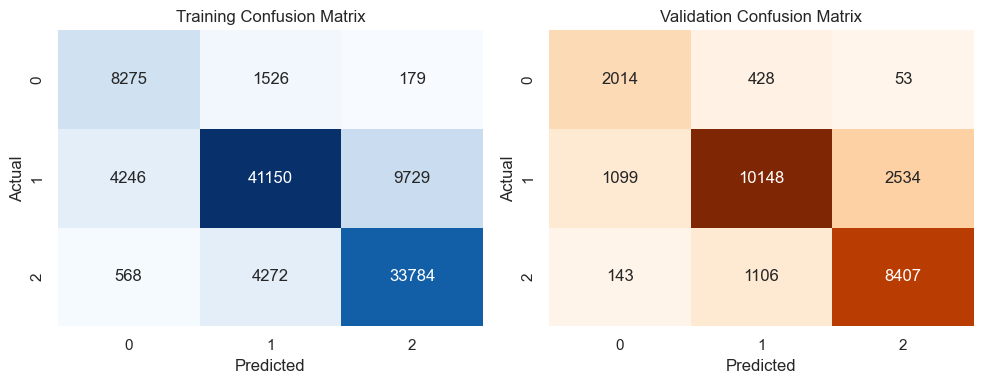

Time taken to run the cell: 3.88 seconds


In [ ]:
# Initialize the LightGBM model
from lightgbm import LGBMClassifier

# Record the start time
start_time = time.time()

lgbm_model = LGBMClassifier(random_state=42, class_weight='balanced')

# Fit the model to the training data
lgbm_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_lgbm_train = lgbm_model.predict(X_train_final)
y_pred_lgbm_val = lgbm_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_lgbm_train, y_val_encoded, y_pred_lgbm_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


#### **CatBoost**

CatBoost is a gradient boosting algorithm specifically optimized for categorical data. It handles imbalanced datasets effectively and reduces the need for extensive preprocessing.

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      9980
           1       0.84      0.86      0.85     55125
           2       0.81      0.85      0.83     38624

    accuracy                           0.84    103729
   macro avg       0.86      0.79      0.82    103729
weighted avg       0.84      0.84      0.84    103729

___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-------------------------------------------------------------------------------

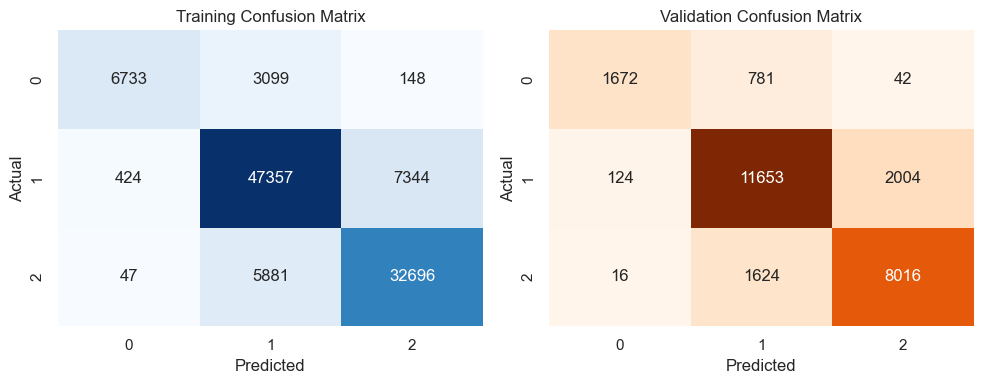

Time taken to run the cell: 32.31 seconds


In [ ]:
# Initialize the CatBoost model
from catboost import CatBoostClassifier

# Record the start time
start_time = time.time()

catboost_model = CatBoostClassifier(random_state=42, verbose=0)

# Fit the model to the training data
catboost_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_catboost_train = catboost_model.predict(X_train_final)
y_pred_catboost_val = catboost_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_catboost_train, y_val_encoded, y_pred_catboost_val)

# Record the end time and calculate duration
end_time = time.time()
print(f"Time taken to run the cell: {end_time - start_time:.2f} seconds")


### 5.3.3. Stacking <a class="anchor" id="sub_section_5_3_3"></a>
[Back to 5.3. Ensemble Models](#section_5_3)<br>

Stacking combines predictions from multiple base models by training a meta-model on their outputs. This leverages the strengths of various algorithms to improve overall performance.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base models
base_models = [
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
]

# Initialize the meta-model
meta_model = LogisticRegression(random_state=42)

# Initialize the Stacking model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Fit the model to the training data
stacking_model.fit(X_train_final, y_train_encoded)

# Predict on the training and validation data
y_pred_stack_train = stacking_model.predict(X_train_final)
y_pred_stack_val = stacking_model.predict(X_val_final)

# Evaluate the model
metrics(y_train_encoded, y_pred_stack_train, y_val_encoded, y_pred_stack_val)

## 5.4. Summary of Models </b> <a class="anchor" id="section_5_4"></a>

[Back to 5. Modelling](#chapter5)<br>

We focused on a select set of models for multiclass classification as the initial results provided promising performance metrics. Below is the performance table, including F1 scores for training and validation datasets, along with the time taken for each model to run.


| **Model**              | **F1 Score (Train)** | **F1 Score (Validation)** | **Time (seconds)** | **Method**                          |
|-------------------------|----------------------|----------------------------|---------------------|-------------------------------------|
| Logistic Regression     | 0.37                | 0.37                       | 6.55                | -                                   |
| Logistic Regression     | 0.35                | 0.35                       | 6.55                | Balanced class weights             |
| Decision Trees          | 0.99                | 0.43                       | -                   | -                                   |
| Decision Trees          | 0.99                | 0.43                       | -                   | Manual class weights               |
| Decision Trees          | 0.75                | 0.46                       | -                   | Grid search                        |
| KNN                     | 0.49                | 0.40                       | 69.96               | -                                   |
| KNN                     | 0.99                | 0.43                       | 780.82              | SMOTE and Grid Search               |
| Neural Networks         | 0.44                | 0.44                       | -                   | Balanced class weights             |
| Neural Networks         | -                   | -                          | -                   | Balanced class weights & grid search |
| Random Forest           | -                   | -                          | -                   | Balanced class weights             |
| Random Forest           | -                   | -                          | -                   | Grid search                        |
| XGBoost                 | -                   | -                          | -                   | -                                   |
| XGBoost                 | -                   | -                          | -                   | Grid search                        |
| LightGBM                | -                   | -                          | -                   | Balanced class weights             |
| CatBoost                | -                   | -                          | -                   | -                                   |
| Stacking                | -                   | -                          | -                   | -                                   |


# 6. Loading the Results <a class="anchor" id="chapter6"></a>

[Back to ToC](#toc)<br>


In [ ]:
# Filter the test data where y_test == 1
X_test_filtered = X_test_final.loc[y_test[y_test == 1].index]

# Remove non-numeric columns (like 'Final_Predictions') before prediction
X_test_filtered_numeric = X_test_filtered.select_dtypes(include=['int', 'float', 'bool', 'category'])

# Apply the model to predict on the filtered numeric test data
y_pred_test_filtered = gb_model.predict(X_test_filtered_numeric)

# Inverse transform the predictions to the original labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train_min)  # Use the encoder already fitted on training data
y_pred_test_original_filtered = label_encoder.inverse_transform(y_pred_test_filtered)

# Add the predictions back to the original test dataset
X_test_final.loc[y_test[y_test == 1.index, 'Pred_notebook_5'] = y_pred_test_original_filtered

# Count the occurrences of each class in the filtered test predictions
class_counts_filtered = pd.Series(y_pred_test_original_filtered).value_counts()

# Display results
print("Predicted Class Counts (Original Labels) for y_test == 1:")
print(class_counts_filtered)


In [ ]:
# Ensure the index alignment before assigning
df_test['Pred_notebook_5'] = X_test_final.loc[df_test.index, 'Pred_notebook_5']

# Save the updated DataFrame to a file
df_test.to_csv('../Data_Temporary/df_test_predictions_not5.csv', index=True)